# Understanding Causal Inference with IHDP: From Theory to Practice - Part 2

## 2. The IHDP Dataset: A Perfect Case Study

### 2.1 Background and Context

> 💡 **Dataset Context**: The Infant Health and Development Program was a randomized controlled intervention designed to evaluate the effect of home visits by specialists on the cognitive development of premature infants.

The Infant Health and Development Program (IHDP) was conducted from 1985 to 1988 and was designed to evaluate the effect of educational and family support services along with pediatric follow-up on the development of low birth weight infants.

The intervention consisted of:
- Home visits by specialists
- Child development center attendance
- Parent group meetings

For causal inference studies, the dataset has been modified by Jennifer Hill (2011) to create a semi-synthetic version where:
- Some participants from the treatment group were removed to create selection bias
- The outcomes were simulated while preserving the relationships with covariates

This modification allows researchers to know the "ground truth" causal effects, making it an ideal benchmark dataset for causal inference methods.

### 2.2 Dataset Structure

Let's load and explore the IHDP dataset:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import urllib.request
import os

# Function to download and load the IHDP dataset
def load_ihdp_data():
    """
    Load the IHDP dataset for causal inference
    
    Returns:
        DataFrame with treatment, outcome, and covariates
    """
    # Create a directory for the data if it doesn't exist
    if not os.path.exists('data'):
        os.makedirs('data')
    
    # Download the data if it doesn't exist
    if not os.path.exists('data/ihdp_npci_1.csv'):
        print("Downloading IHDP dataset...")
        url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
        urllib.request.urlretrieve(url, 'data/ihdp_npci_1.csv')
    
    # Load the data
    data = pd.read_csv('data/ihdp_npci_1.csv')
    
    # Rename columns for clarity
    column_names = ['treatment']
    column_names.extend([f'y_{i}' for i in range(2)])  # factual and counterfactual outcomes
    column_names.extend([f'mu_{i}' for i in range(2)])  # expected outcomes without noise
    column_names.extend([f'x_{i}' for i in range(25)])  # covariates
    
    data.columns = column_names
    
    # Rename for more intuitive understanding
    data.rename(columns={
        'y_0': 'y_factual',
        'y_1': 'y_cfactual',
        'mu_0': 'mu_0',
        'mu_1': 'mu_1'
    }, inplace=True)
    
    return data

# Load the IHDP dataset
ihdp_data = load_ihdp_data()

# Display the first few rows
print("IHDP Dataset Preview:")
print(ihdp_data.head())

# Display basic dataset information
print("\nDataset Information:")
print(f"Number of samples: {ihdp_data.shape[0]}")
print(f"Number of variables: {ihdp_data.shape[1]}")
print(f"Treatment assignment rate: {ihdp_data['treatment'].mean():.2f}")

# Display column information
print("\nColumn Types:")
print(ihdp_data.dtypes)

IHDP Dataset Preview:
   treatment  y_factual  y_cfactual      mu_0      mu_1       x_0       x_1  \
0          0   6.875856    7.856495  6.636059  7.562718 -1.736945 -1.802002   
1          0   2.996273    6.633952  1.570536  6.121617 -0.807451 -0.202946   
2          0   1.366206    5.697239  1.244738  5.889125  0.390083  0.596582   
3          0   1.963538    6.202582  1.685048  6.191994 -1.045229 -0.602710   
4          0   4.762090    8.264795  4.707898  7.219442  0.467901 -0.202946   

        x_2       x_3       x_4  ...  x_15  x_16  x_17  x_18  x_19  x_20  \
0  0.383828  2.244320 -0.629189  ...     1     1     1     1     0     0   
1 -0.360898 -0.879606  0.808706  ...     1     0     1     1     0     0   
2 -1.850350 -0.879606 -0.004017  ...     1     0     1     1     0     0   
3  0.011465  0.161703  0.683672  ...     1     1     1     1     0     0   
4 -0.733261  0.161703  0.058500  ...     1     1     1     1     0     0   

   x_21  x_22  x_23  x_24  
0     0     0     

**Understanding the Dataset Structure:**

The IHDP dataset contains:
- `treatment`: Binary indicator (1 = received intervention, 0 = control)
- `y_factual`: The observed outcome (only Y(1) or Y(0) depending on treatment)
- `y_cfactual`: The counterfactual outcome (what would have happened under the opposite treatment)
- `mu_0`: The expected outcome under control without noise
- `mu_1`: The expected outcome under treatment without noise
- `x_0` to `x_24`: 25 covariates representing baseline characteristics

Let's examine the covariates and understand their meaning:

In [2]:
# Describe the covariates
covariate_descriptions = {
    'x_0': 'Child\'s birth weight (grams)',
    'x_1': 'Child\'s birth order',
    'x_2': 'Head circumference at birth (cm)',
    'x_3': 'Mother\'s age at birth (years)',
    'x_4': 'Mother\'s education (years)',
    'x_5': 'Child\'s gender (1=male, 0=female)',
    'x_6': 'Twin (1=yes, 0=no)',
    'x_7': 'Number of previous neonatal deaths',
    'x_8': 'Mother\'s marital status (1=married, 0=not married)',
    'x_9': 'Mother smoked during pregnancy (1=yes, 0=no)',
    'x_10': 'Mother drank alcohol during pregnancy (1=yes, 0=no)',
    'x_11': 'Mother used drugs during pregnancy (1=yes, 0=no)',
    'x_12': 'Child\'s neonatal health index',
    'x_13': 'Mom white (1=yes, 0=no)',
    'x_14': 'Mom black (1=yes, 0=no)',
    'x_15': 'Mom Hispanic (1=yes, 0=no)',
    'x_16': 'Mom is employed (1=yes, 0=no)',
    'x_17': 'Family receives welfare (1=yes, 0=no)',
    'x_18': 'Mother works during pregnancy (1=yes, 0=no)',
    'x_19': 'Prenatal care visit in first trimester (1=yes, 0=no)',
    'x_20': 'Site 1 (1=yes, 0=no)',
    'x_21': 'Site 2 (1=yes, 0=no)',
    'x_22': 'Site 3 (1=yes, 0=no)',
    'x_23': 'Site 4 (1=yes, 0=no)',
    'x_24': 'Site 5 (1=yes, 0=no)'
}

# Create a DataFrame with descriptions
covariates_df = pd.DataFrame({
    'Variable': covariate_descriptions.keys(),
    'Description': covariate_descriptions.values()
})

print("Covariate Descriptions:")
print(covariates_df)

# Calculate summary statistics for numerical covariates
numerical_covs = [f'x_{i}' for i in range(5)] + ['x_12']
print("\nNumerical Covariate Statistics:")
print(ihdp_data[numerical_covs].describe())

# Calculate rates for binary covariates
binary_covs = [f'x_{i}' for i in range(5, 25) if i != 12]
binary_rates = ihdp_data[binary_covs].mean().reset_index()
binary_rates.columns = ['Variable', 'Rate']
binary_rates['Description'] = binary_rates['Variable'].map(covariate_descriptions)

print("\nBinary Covariate Rates:")
print(binary_rates)

Covariate Descriptions:
   Variable                                        Description
0       x_0                       Child's birth weight (grams)
1       x_1                                Child's birth order
2       x_2                   Head circumference at birth (cm)
3       x_3                      Mother's age at birth (years)
4       x_4                         Mother's education (years)
5       x_5                  Child's gender (1=male, 0=female)
6       x_6                                 Twin (1=yes, 0=no)
7       x_7                 Number of previous neonatal deaths
8       x_8  Mother's marital status (1=married, 0=not marr...
9       x_9       Mother smoked during pregnancy (1=yes, 0=no)
10     x_10  Mother drank alcohol during pregnancy (1=yes, ...
11     x_11   Mother used drugs during pregnancy (1=yes, 0=no)
12     x_12                      Child's neonatal health index
13     x_13                            Mom white (1=yes, 0=no)
14     x_14                    

### 2.3 Exploratory Data Analysis

Let's explore the treatment assignment and outcomes:

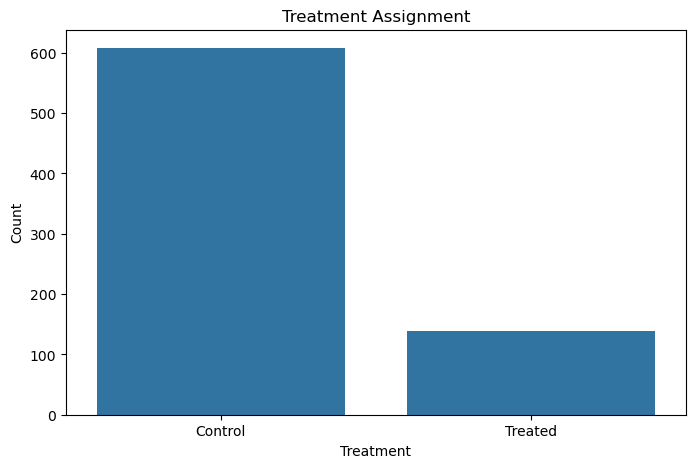

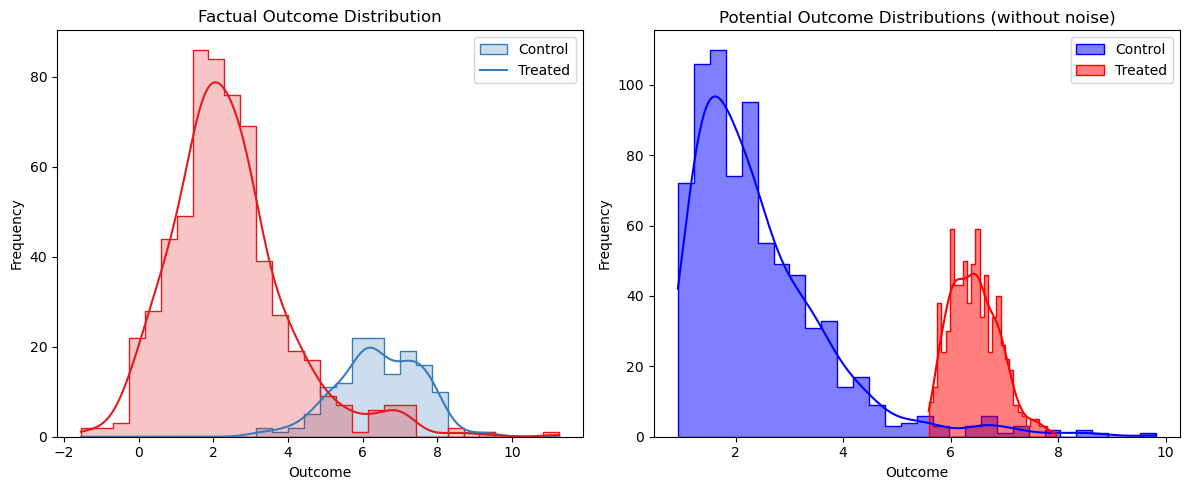

True Average Treatment Effect: 4.0166


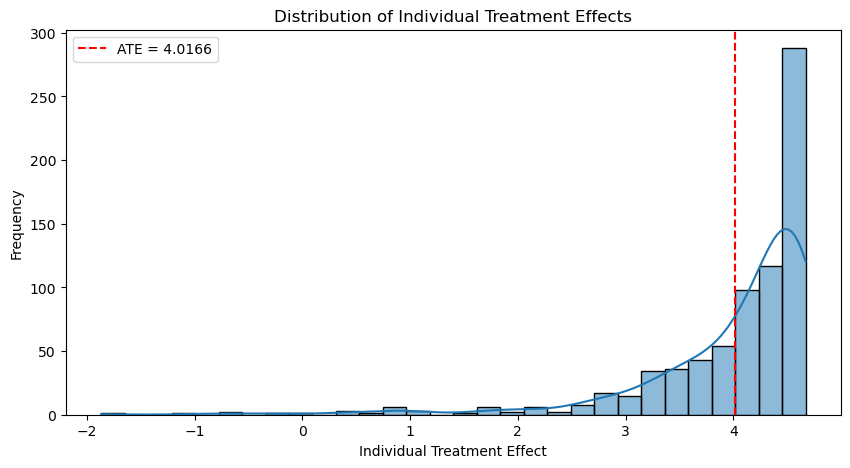

In [3]:
# Treatment group sizes
treatment_counts = ihdp_data['treatment'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=treatment_counts.index, y=treatment_counts.values)
plt.title('Treatment Assignment')
plt.xlabel('Treatment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Control', 'Treated'])
plt.show()

# Outcome distributions
plt.figure(figsize=(12, 5))

# Plot factual outcomes
plt.subplot(1, 2, 1)
sns.histplot(data=ihdp_data, x='y_factual', hue='treatment', bins=30, kde=True, 
             element='step', common_norm=False, palette='Set1')
plt.title('Factual Outcome Distribution')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.legend(['Control', 'Treated'])

# Plot potential outcomes (using mu_0 and mu_1 which are expected outcomes without noise)
plt.subplot(1, 2, 2)
sns.histplot(data=ihdp_data, x='mu_0', bins=30, kde=True, 
             element='step', color='blue', alpha=0.5, label='Control')
sns.histplot(data=ihdp_data, x='mu_1', bins=30, kde=True, 
             element='step', color='red', alpha=0.5, label='Treated')
plt.title('Potential Outcome Distributions (without noise)')
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate the true average treatment effect (ATE)
true_ate = ihdp_data['mu_1'].mean() - ihdp_data['mu_0'].mean()
print(f"True Average Treatment Effect: {true_ate:.4f}")

# Calculate individual treatment effects
ihdp_data['ite'] = ihdp_data['mu_1'] - ihdp_data['mu_0']

# Plot individual treatment effects
plt.figure(figsize=(10, 5))
sns.histplot(data=ihdp_data, x='ite', bins=30, kde=True)
plt.axvline(x=true_ate, color='red', linestyle='--', label=f'ATE = {true_ate:.4f}')
plt.title('Distribution of Individual Treatment Effects')
plt.xlabel('Individual Treatment Effect')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Analysis:** These visualizations help us understand:
1. The distribution of treatment assignment (treatment imbalance)
2. The distribution of observed outcomes for treated and control groups
3. The distributions of potential outcomes for all units
4. The distribution of individual treatment effects, which shows heterogeneity in how individuals respond to treatment

Next, let's examine covariate balance between treated and control groups:

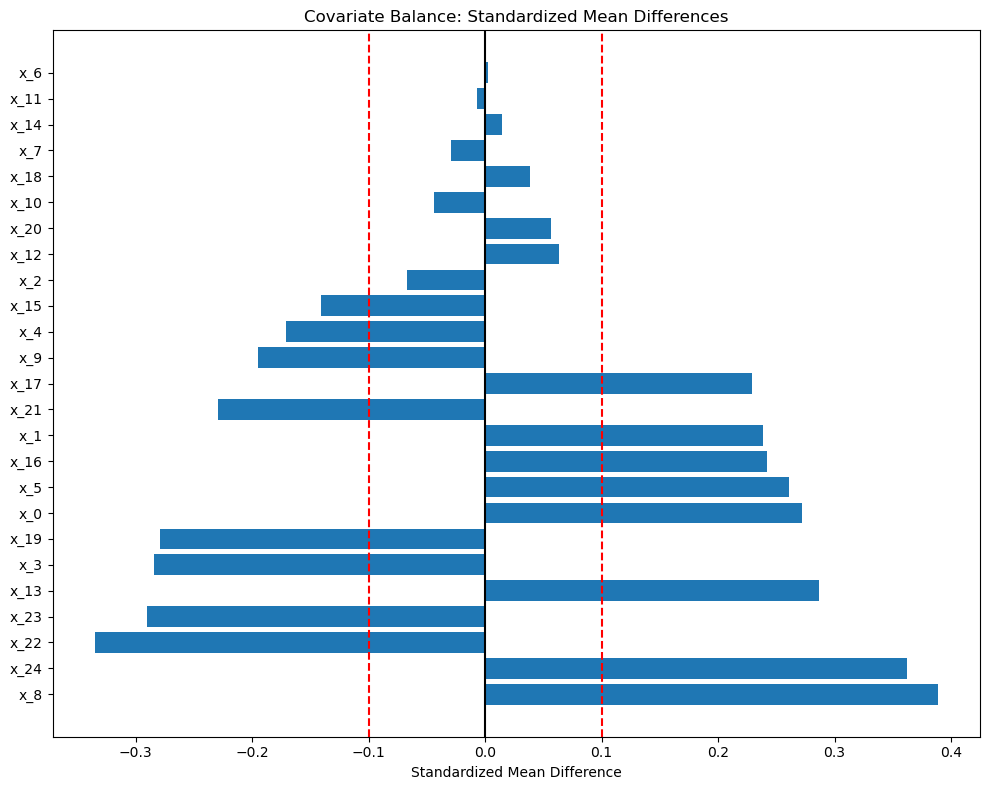

Covariate Balance Statistics:
   Covariate       SMD  Mean_Treated  Mean_Control
8        x_8  0.388650      0.673913      0.485197
24      x_24  0.362042      0.275362      0.131579
22      x_22 -0.335079      0.014493      0.087171
23      x_23 -0.290025      0.057971      0.144737
13      x_13  0.286746      1.579710      1.437500
3        x_3 -0.284120     -0.223129      0.050378
19      x_19 -0.279311      0.065217      0.151316
0        x_0  0.272119      0.215431     -0.048028
5        x_5  0.260635      0.204313     -0.048504
16      x_16  0.241631      0.688406      0.572368
1        x_1  0.238498      0.186590     -0.041786
21      x_21 -0.229122      0.036232      0.092105
17      x_17  0.228669      0.992754      0.957237
9        x_9 -0.194737      0.289855      0.381579
4        x_4 -0.170572     -0.140830      0.032485
15      x_15 -0.140901      0.934783      0.965461
2        x_2 -0.067509     -0.053294      0.010240
12      x_12  0.062978      0.384058      0.353618
2

In [4]:
# Function to calculate and plot standardized mean differences
def plot_covariate_balance(data, treatment_col, covariates):
    # Calculate standardized mean differences
    balance_stats = []
    
    for covariate in covariates:
        # Get means for treated and control
        mean_treated = data.loc[data[treatment_col] == 1, covariate].mean()
        mean_control = data.loc[data[treatment_col] == 0, covariate].mean()
        
        # Get standard deviations
        sd_treated = data.loc[data[treatment_col] == 1, covariate].std()
        sd_control = data.loc[data[treatment_col] == 0, covariate].std()
        
        # Calculate pooled standard deviation
        pooled_sd = np.sqrt((sd_treated**2 + sd_control**2) / 2)
        
        # Calculate standardized mean difference
        if pooled_sd == 0:
            smd = 0
        else:
            smd = (mean_treated - mean_control) / pooled_sd
        
        # Add to results
        balance_stats.append({
            'Covariate': covariate,
            'SMD': smd,
            'Mean_Treated': mean_treated,
            'Mean_Control': mean_control
        })
    
    # Convert to DataFrame
    balance_df = pd.DataFrame(balance_stats)
    
    # Sort by absolute SMD
    balance_df = balance_df.reindex(balance_df['SMD'].abs().sort_values(ascending=False).index)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(balance_df['Covariate'], balance_df['SMD'])
    plt.axvline(x=0, color='black', linestyle='-')
    plt.axvline(x=0.1, color='red', linestyle='--')
    plt.axvline(x=-0.1, color='red', linestyle='--')
    plt.title('Covariate Balance: Standardized Mean Differences')
    plt.xlabel('Standardized Mean Difference')
    plt.tight_layout()
    plt.show()
    
    return balance_df

# List of covariates
covariates = [f'x_{i}' for i in range(25)]

# Plot covariate balance
balance_df = plot_covariate_balance(ihdp_data, 'treatment', covariates)
print("Covariate Balance Statistics:")
print(balance_df)

**Analysis:** The covariate balance plot shows the standardized mean differences (SMD) between treated and control groups for each covariate. Values outside the dashed red lines (±0.1) indicate meaningful imbalance. This imbalance reflects the selection bias introduced in the dataset, where the treatment assignment is not random but depends on covariates.

### 2.4 Why IHDP is Ideal for Causal Inference

The IHDP dataset has several characteristics that make it valuable for learning causal inference:

1. **Known ground truth**: Since outcomes are simulated with a known data-generating process, we can evaluate methods against the true causal effects.

2. **Realistic complexity**: The dataset reflects real-world complexity with mixed continuous and categorical variables.

3. **Selection bias**: The non-random treatment assignment mimics real observational studies.

4. **Availability of counterfactuals**: Unlike most real-world datasets, IHDP has both factual and counterfactual outcomes for validation.

5. **Heterogeneous treatment effects**: The effects vary across individuals, allowing us to study methods for capturing this heterogeneity.

AUC for predicting treatment from covariates: 0.7442


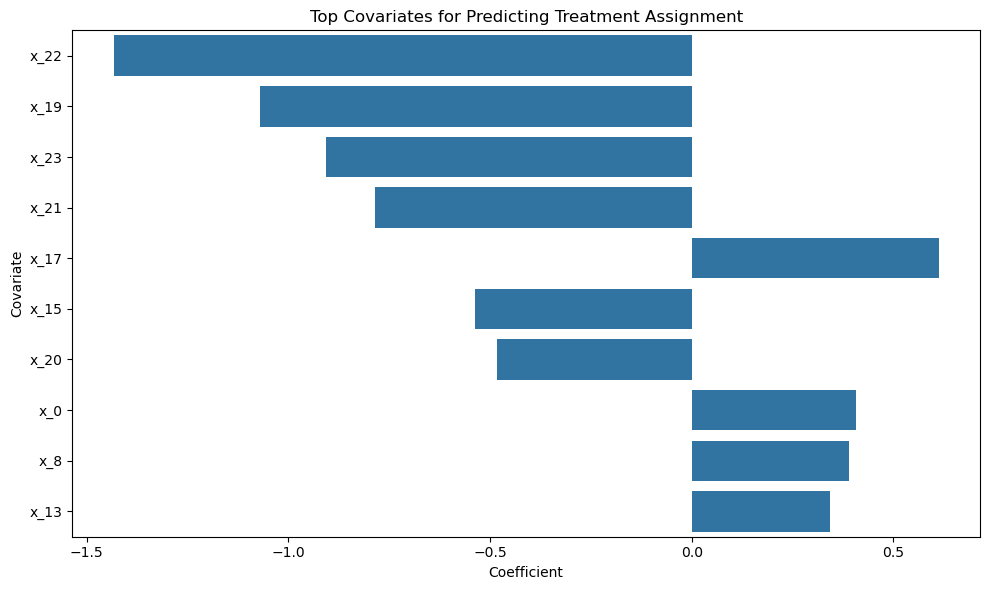

In [5]:
# Demonstrate the relationship between covariates and treatment assignment
# Let's fit a simple logistic regression model to predict treatment from covariates
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Prepare X and y
X = ihdp_data[[f'x_{i}' for i in range(25)]]
y = ihdp_data['treatment']

# Fit the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)

# Get predictions
y_pred_prob = log_reg.predict_proba(X)[:, 1]

# Calculate AUC
auc = roc_auc_score(y, y_pred_prob)

print(f"AUC for predicting treatment from covariates: {auc:.4f}")

# Get feature importances (coefficients)
coef_df = pd.DataFrame({
    'Covariate': [f'x_{i}' for i in range(25)],
    'Coefficient': log_reg.coef_[0],
    'Abs_Coefficient': np.abs(log_reg.coef_[0])
})

# Sort by absolute coefficient
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Covariate', data=coef_df.head(10))
plt.title('Top Covariates for Predicting Treatment Assignment')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.show()

**Analysis:** The high AUC score indicates that covariates strongly predict treatment assignment, confirming the presence of selection bias. This mimics real-world observational studies where treatment assignment is not random but depends on observed characteristics.

## Resources and References

- Hill, J. L. (2011). Bayesian nonparametric modeling for causal inference. Journal of Computational and Graphical Statistics, 20(1), 217-240.
- [IHDP Dataset Repository](https://github.com/AMLab-Amsterdam/CEVAE/tree/master/datasets/IHDP)
- [Causal Inference with Python Part 1: Potential Outcomes](https://medium.com/towards-data-science/causal-inference-with-python-part-1-potential-outcomes-ff14d5a330cd)
- [Why use IHDP for causal inference benchmarking](https://www.fredjo.com/)